In [1]:
from src.datasets import read_data
import pandas as pd
from src.preprocess import *

In [2]:
all_pd = pd.read_csv("../outputs/EDA_data.csv", index_col='Id')
old_train_pd = read_data("train.csv")
old_is_category = find_list_category_columns(old_train_pd)

In [3]:
is_category = pd.Series([True] * len(all_pd.columns), index=all_pd.columns)
is_category.loc[old_is_category[old_is_category == False].index] = False

In [4]:
new_category = ['MSSubClass', 'MoSold', 'YrSold', 'OverallQual', 'OverallCond']
new_quant = ['TotBathrooms', 'HouseAge', 'TotalSqFeet', 'TotalPorchSF', ]
is_category.loc[new_category] = True
is_category.loc[new_quant] = False

In [5]:
len(is_category[is_category==False])

36

In [5]:
train_pd = all_pd.loc[:1460]
imputer = RemovelColsImputer(is_category)
train_pd = imputer.fit_transform(train_pd)
cols_level = find_col_levels(all_pd, is_category)


In [6]:
predictor_cols = [x for x in train_pd.columns if x != 'SalePrice']
target_col = 'SalePrice'

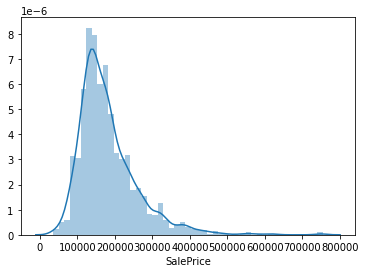

In [11]:
import seaborn as sns
sns.distplot(train_pd['SalePrice'])

In [13]:
from scipy.stats import skew
skew(train_pd['SalePrice'])

1.880940746034036

In [8]:
from src.process_functions import *
model_ = get_model(ModelOLSStats, train_pd, cols_level, predictor_cols, target_col)
results_fit = select_features_step(train_pd, model_, "mix")
results_cv = get_results_cv(results_fit, model_)
selection = plain_selection(results_cv)
final_cols, final_model = selection["cols"], selection["results"]

output_info = f"Final results: With cols = {final_cols} - number_features = {len(final_cols)} - cv_score: {np.sqrt(selection['cv_score_mean'])}"
logger.info(output_info)

2020-05-01 16:37:25 6898 MainThread feature_selection.py: 42  INFO--: [select_features_withstats_ols] Current itteration: 1
2020-05-01 16:37:27 6898 MainThread feature_selection.py: 78  INFO--: [select_features_withstats_ols] Select feature OverallQual with imporve rss = 0.052764433925178426
2020-05-01 16:37:27 6898 MainThread feature_selection.py: 42  INFO--: [select_features_withstats_ols] Current itteration: 2
select_cols =  ['OverallQual']
2020-05-01 16:37:29 6898 MainThread feature_selection.py: 78  INFO--: [select_features_withstats_ols] Select feature TotalSqFeet with imporve rss = 0.035268932747419886
2020-05-01 16:37:29 6898 MainThread feature_selection.py: 42  INFO--: [select_features_withstats_ols] Current itteration: 3
select_cols =  ['OverallQual', 'TotalSqFeet']
2020-05-01 16:37:33 6898 MainThread feature_selection.py: 78  INFO--: [select_features_withstats_ols] Select feature Neighborhood with imporve rss = 0.027156782508461635
2020-05-01 16:37:33 6898 MainThread feature

In [10]:
test_pd = all_pd[1460:]
test_result = final_model.predict(test_pd[final_cols])
test_result = pd.concat([pd.Series(test_pd.index, name="Id"), test_result], axis=1)
output_path =  "../outputs"
test_result.to_csv(os.path.join(output_path, f"new_eda_output_mix.csv"), index=False)